# Findings so far
- `Dew point temperature` is extremely correlated with `Temperature` (0.96) and provides no unique insight or effect on bike rentals
- `Functioning Day` determines whether the bike shop is open or not. If it's not open, no rentals. This is impossible for the model to learn when there are only 12 days so the feature was removed
	- Consequently, the rows where the bike shop were closed were also removed because keeping them would mislead the model in believing that good weather sometimes leads in no rentals
- `Holiday` was removed because there are very few holidays (class imblanace) and a very poor correlation with the target value (-0.11)
- `Hour` was removed as a result of aggregating to daily obervations
- `Visibility` was removed as it provided little to no effect on bike rentals and only contributed to noise within the dataset
- `Snowfall` was removed as it provided a similar effect on bike rentals as rainfall. Removing it contributed in lowering overfitting and RMSE (reduced noise)\
- Creating a weekend vs weekday feature helped slightly in metrics
## Moving Forward
There seems to be some non-linear activity within the features (residual plot heteroskedasticity) so that needs to be investigated

In [ ]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
# %load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import prepData, transformData
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from sklearn.inspection import partial_dependence
import shap
import itertools
from IPython.display import clear_output

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough

df = prepData(df)
display(df)

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import ExtraTreesRegressor

# pulled from modeling file
reg = HuberRegressor(alpha=1e-3, epsilon=1.35, max_iter=1000)
tree = ExtraTreesRegressor(max_depth=7,min_samples_leaf=3,min_samples_split=2,n_estimators=363, random_state=1)

Rented Bike Count  Temperature(C)  Humidity(%)  Wind Speed(m/s)  \
Date                                                                          
2017-12-01               9539       -2.454167    45.875000         1.537500   
2017-12-02               8523        1.325000    61.958333         1.712500   
2017-12-03               7222        4.875000    81.541667         1.612500   
2017-12-04               8729       -0.304167    52.500000         3.450000   
2017-12-05               8307       -4.458333    36.416667         1.108333   
...                       ...             ...          ...              ...   
2018-11-26              17162        6.320833    70.500000         1.029167   
2018-11-27              16282        7.066667    68.000000         1.350000   
2018-11-28              16524        5.304167    25.791667         1.695833   
2018-11-29              16423        3.304167    38.000000         1.212500   
2018-11-30              16297        2.762500    47.208333         1.433333   

            Solar Radiation(MJ/m2)  Rainfall(mm)  Spring  Summer  Autumn  \
Date                                                                       
2017-12-01                    1.16           0.0       0       0       0   
2017-12-02                    1.12           0.0       0       0       0   
2017-12-03                    0.69           4.0       0       0       0   
2017-12-04                    1.17           0.1       0       0       0   
2017-12-05                    0.64           0.0       0       0       0   
...                            ...           ...     ...     ...     ...   
2018-11-26                    1.74           0.0       0       0       1   
2018-11-27                    0.87           0.0       0       0       1   
2018-11-28                    1.86           0.0       0       0       1   
2018-11-29                    0.64           0.0       0       0       1   
2018-11-30                    1.83           0.0       0       0       1   

            Winter  Weekend  Summer*Temp  
Date                                      
2017-12-01       1        0         -0.0  
2017-12-02       1        1          0.0  
2017-12-03       1        1          0.0  
2017-12-04       1        0         -0.0  
2017-12-05       1        0         -0.0  
...            ...      ...          ...  
2018-11-26       0        0          0.0  
2018-11-27       0        0          0.0  
2018-11-28       0        0          0.0  
2018-11-29       0        0          0.0  
2018-11-30       0        0          0.0  

[353 rows x 12 columns]

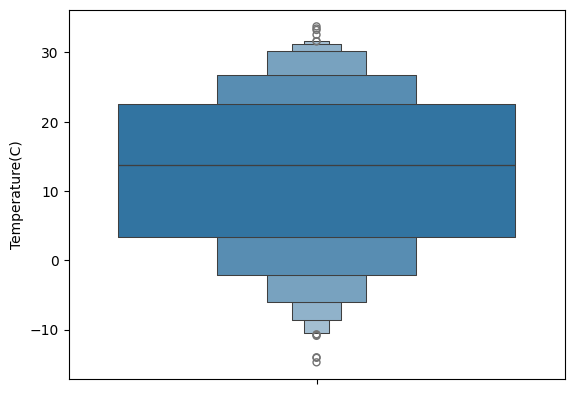

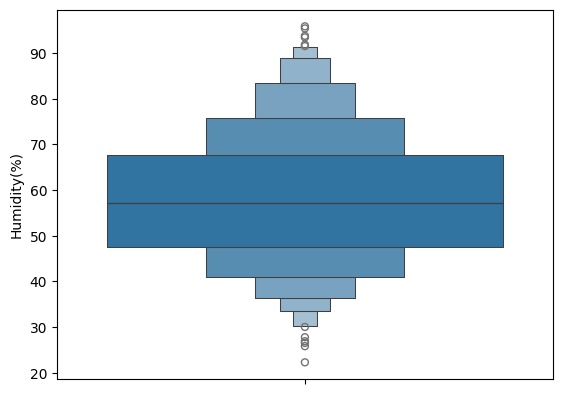

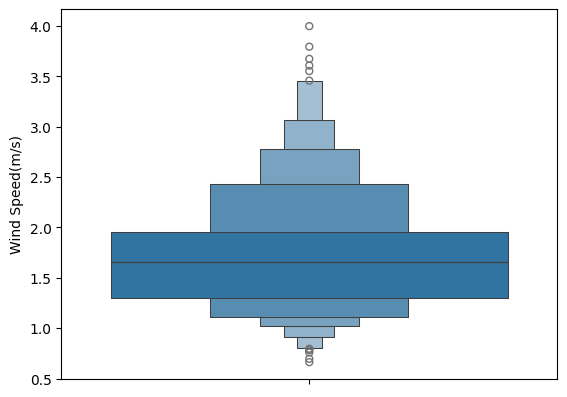

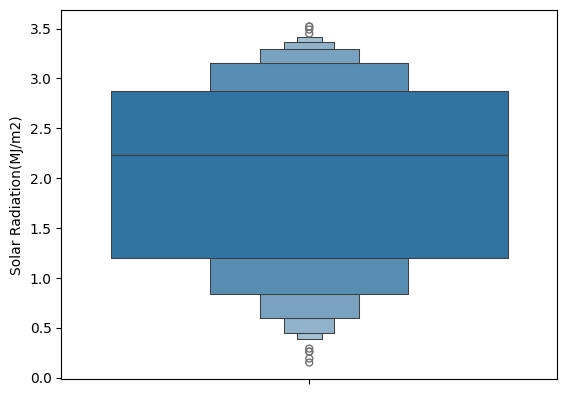

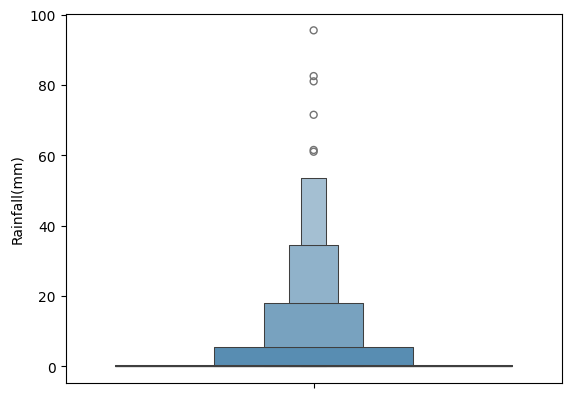

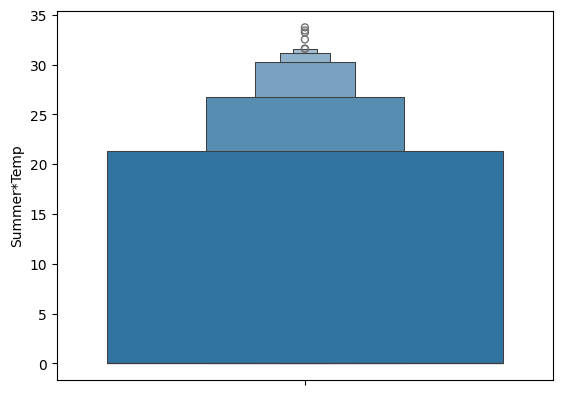

In [99]:
cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(m/s)', 'Solar Radiation(MJ/m2)', 'Rainfall(mm)', 'Summer*Temp'] # 'Snowfall(mm)',
for col in cols:
	sns.boxenplot(df[col])
	plt.show()

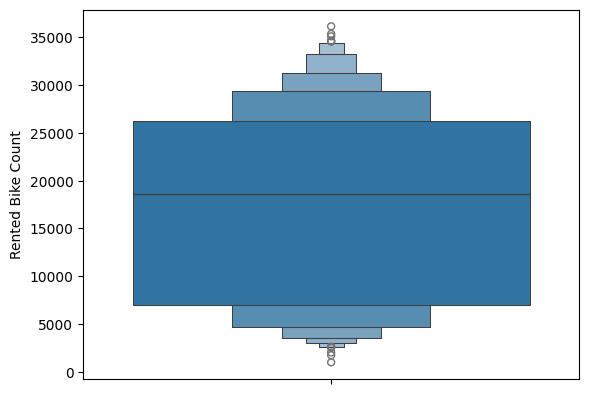

In [98]:
sns.boxenplot(df['Rented Bike Count'])
plt.show()

In [93]:
y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)
# X_train = pd.DataFrame(X_train, columns=X.columns) # so we can visualize everything nicely
# X_test = pd.DataFrame(X_test, columns=X.columns) # so we can visualize everything nicely

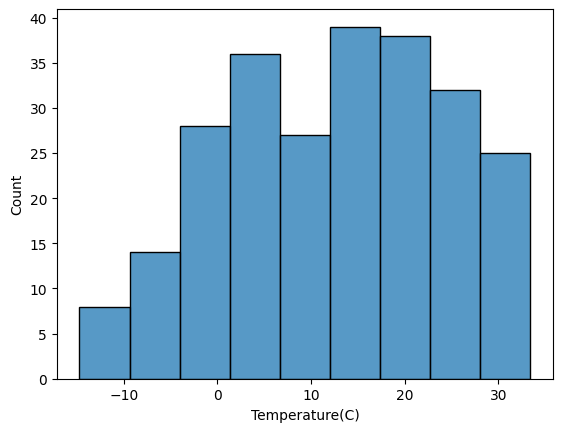

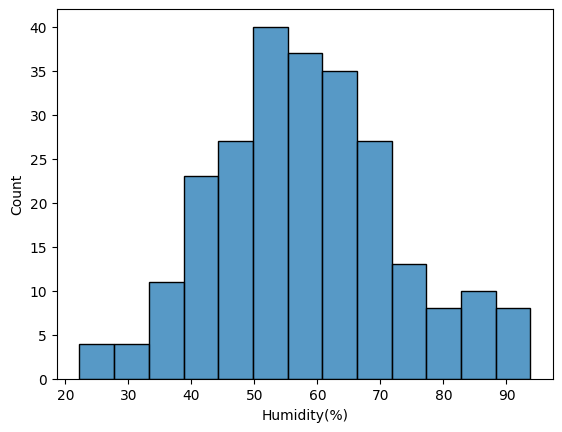

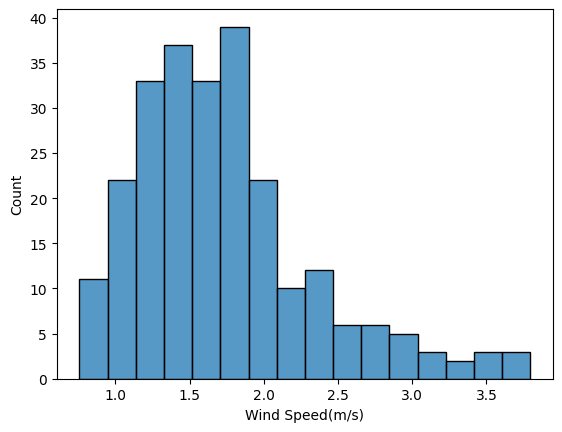

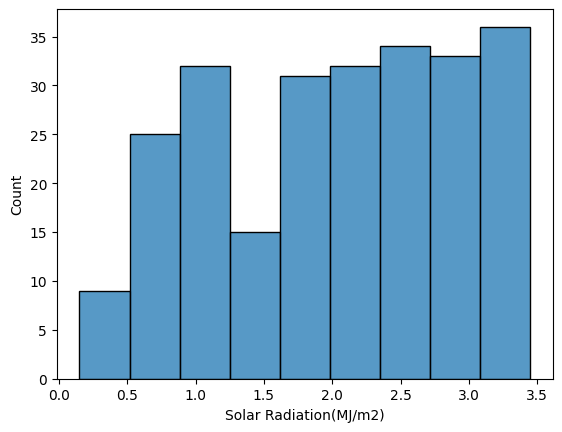

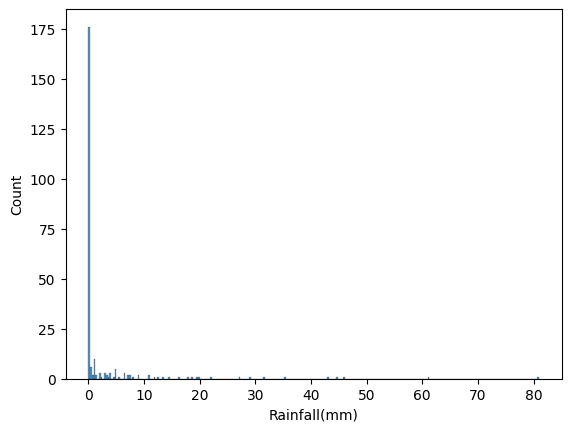

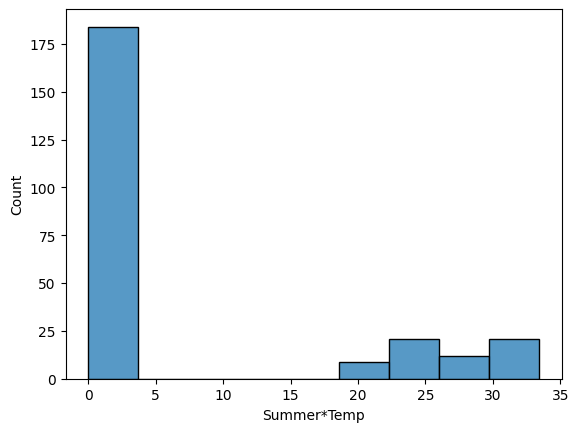

In [23]:
for col in cols:
	sns.histplot(X_train[col])
	plt.show()

In [34]:
def pdp(model):
    model.fit(X_train, y_train)
    # List of all feature names
    features = list(X_train.columns)
    # Generate all unique pairs
    feature_pairs = list(itertools.combinations(features, 2))
    # Store results
    interaction_scores = []
    # Loop over each pair and compute the 2D partial dependence surface
    for pair in feature_pairs:
        try:
            pd_result = partial_dependence(model, X_train, list(pair))
            values = pd_result['average'][0]  # shape: (n_vals_1, n_vals_2)
            # Use std deviation or range as a simple interaction strength proxy
            interaction_strength = np.std(values)  # or np.ptp(values) for range
            interaction_scores.append({
                'feature_1': pair[0],
                'feature_2': pair[1],
                'interaction_strength': interaction_strength
            })
            
        except Exception as e:
            print(f"Skipping {pair}: {e}")

    # Convert to DataFrame and sort
    interaction_df = pd.DataFrame(interaction_scores)
    interaction_df = interaction_df.sort_values(by='interaction_strength', ascending=False)
    clear_output(True)
    return interaction_df

In [101]:
reg_results = pdp(reg)

In [102]:
display(reg_results.head(20))

feature_1               feature_2  interaction_strength
6           Temperature(C)                  Summer           5884.020481
3           Temperature(C)            Rainfall(mm)           5856.653536
2           Temperature(C)  Solar Radiation(MJ/m2)           5848.161994
8           Temperature(C)                  Winter           5618.538379
4           Temperature(C)             Summer*Temp           5358.491353
5           Temperature(C)                  Spring           5259.928002
9           Temperature(C)                 Weekend           5199.453937
7           Temperature(C)                  Autumn           5136.923188
1           Temperature(C)         Wind Speed(m/s)           5088.014233
0           Temperature(C)             Humidity(%)           5086.416129
36            Rainfall(mm)                  Summer           4196.312488
30  Solar Radiation(MJ/m2)                  Summer           4184.452958
27  Solar Radiation(MJ/m2)            Rainfall(mm)           4145.882317
50                  Summer                  Winter           3857.022345
38            Rainfall(mm)                  Winter           3815.142854
32  Solar Radiation(MJ/m2)                  Winter           3802.094562
41             Summer*Temp                  Summer           3467.286753
34            Rainfall(mm)             Summer*Temp           3420.638984
28  Solar Radiation(MJ/m2)             Summer*Temp           3406.079728
45                  Spring                  Summer           3312.927774

In [42]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse = np.sqrt(mse_test)

    #clear_output(True)
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Alternatively, it's off by an average of {round(rmse)} bikes")

    # keeping our visualizations in the transformed space
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()

Test Accuracy: 85.52%
Train Accuracy: 85.07%
Accuracy Difference: 0.45%
Test Mean Squared Error: 13901016.36
Root Mean Squared Error: 3728.41
Alternatively, it's off by an average of 3728 bikes


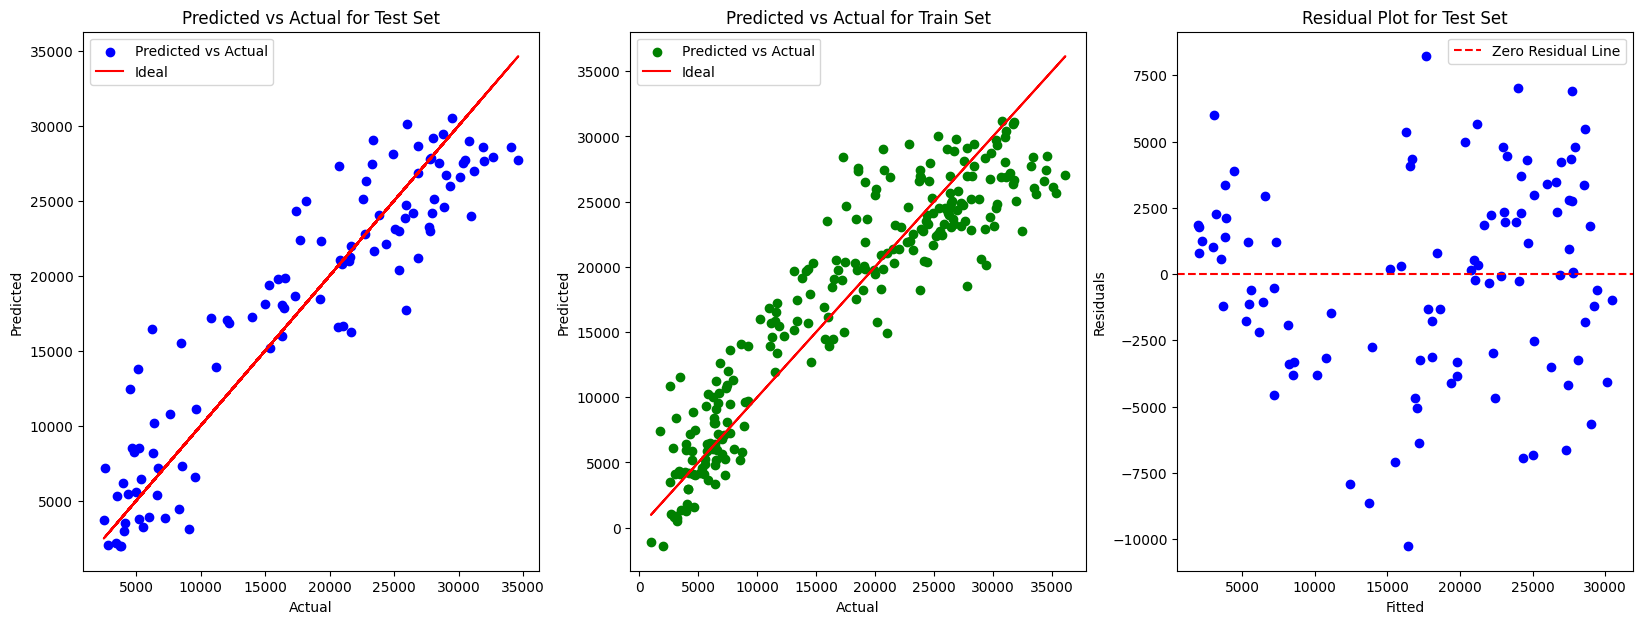

In [111]:
test_model(reg)

Test Accuracy: 90.82%
Train Accuracy: 95.48%
Accuracy Difference: -4.67%
Test Mean Squared Error: 8811861.03
Root Mean Squared Error: 2968.48
Alternatively, it's off by an average of 2968 bikes


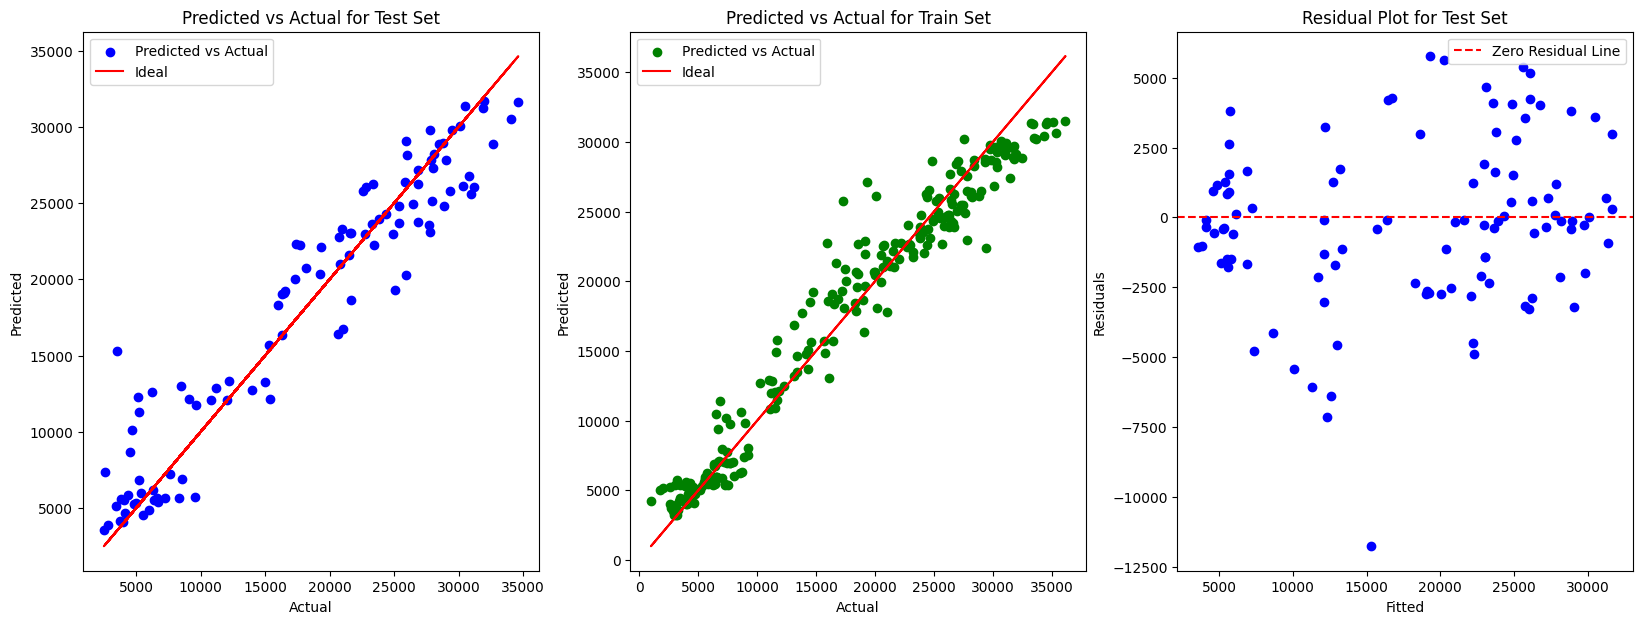

In [95]:
test_model(tree)

In [112]:
feature_names = X_train.columns

# Get coefficients
coefs = reg.coef_

# Create DataFrame of importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefs
})

# Sort by absolute importance
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

print(importance_df[['Feature', 'Importance']])

                   Feature   Importance
7                   Summer  5988.379559
0           Temperature(C)  5458.824603
9                   Winter -4862.694288
5              Summer*Temp -4134.242330
3   Solar Radiation(MJ/m2)  3241.513536
6                   Spring -2835.713667
10                 Weekend -2347.591668
8                   Autumn  1710.503152
4             Rainfall(mm) -1614.257639
2          Wind Speed(m/s)  -495.289552
1              Humidity(%)  -470.641360


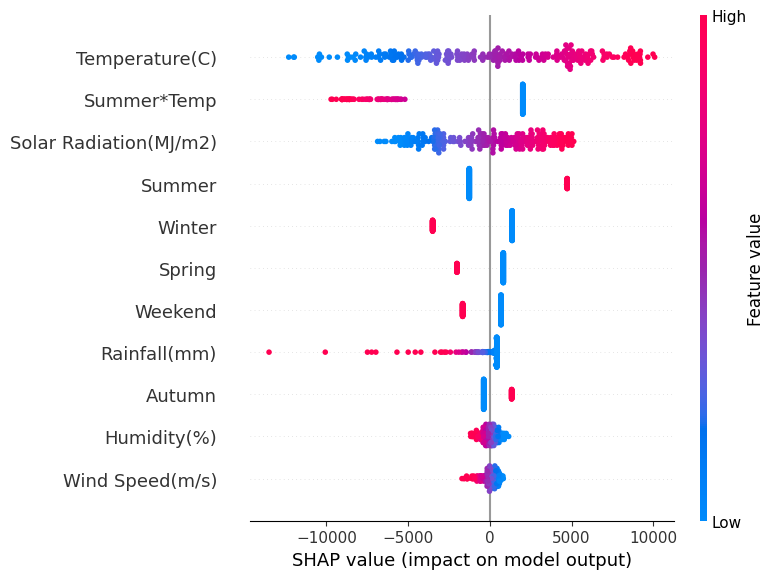

In [106]:
explainer = shap.LinearExplainer(reg, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

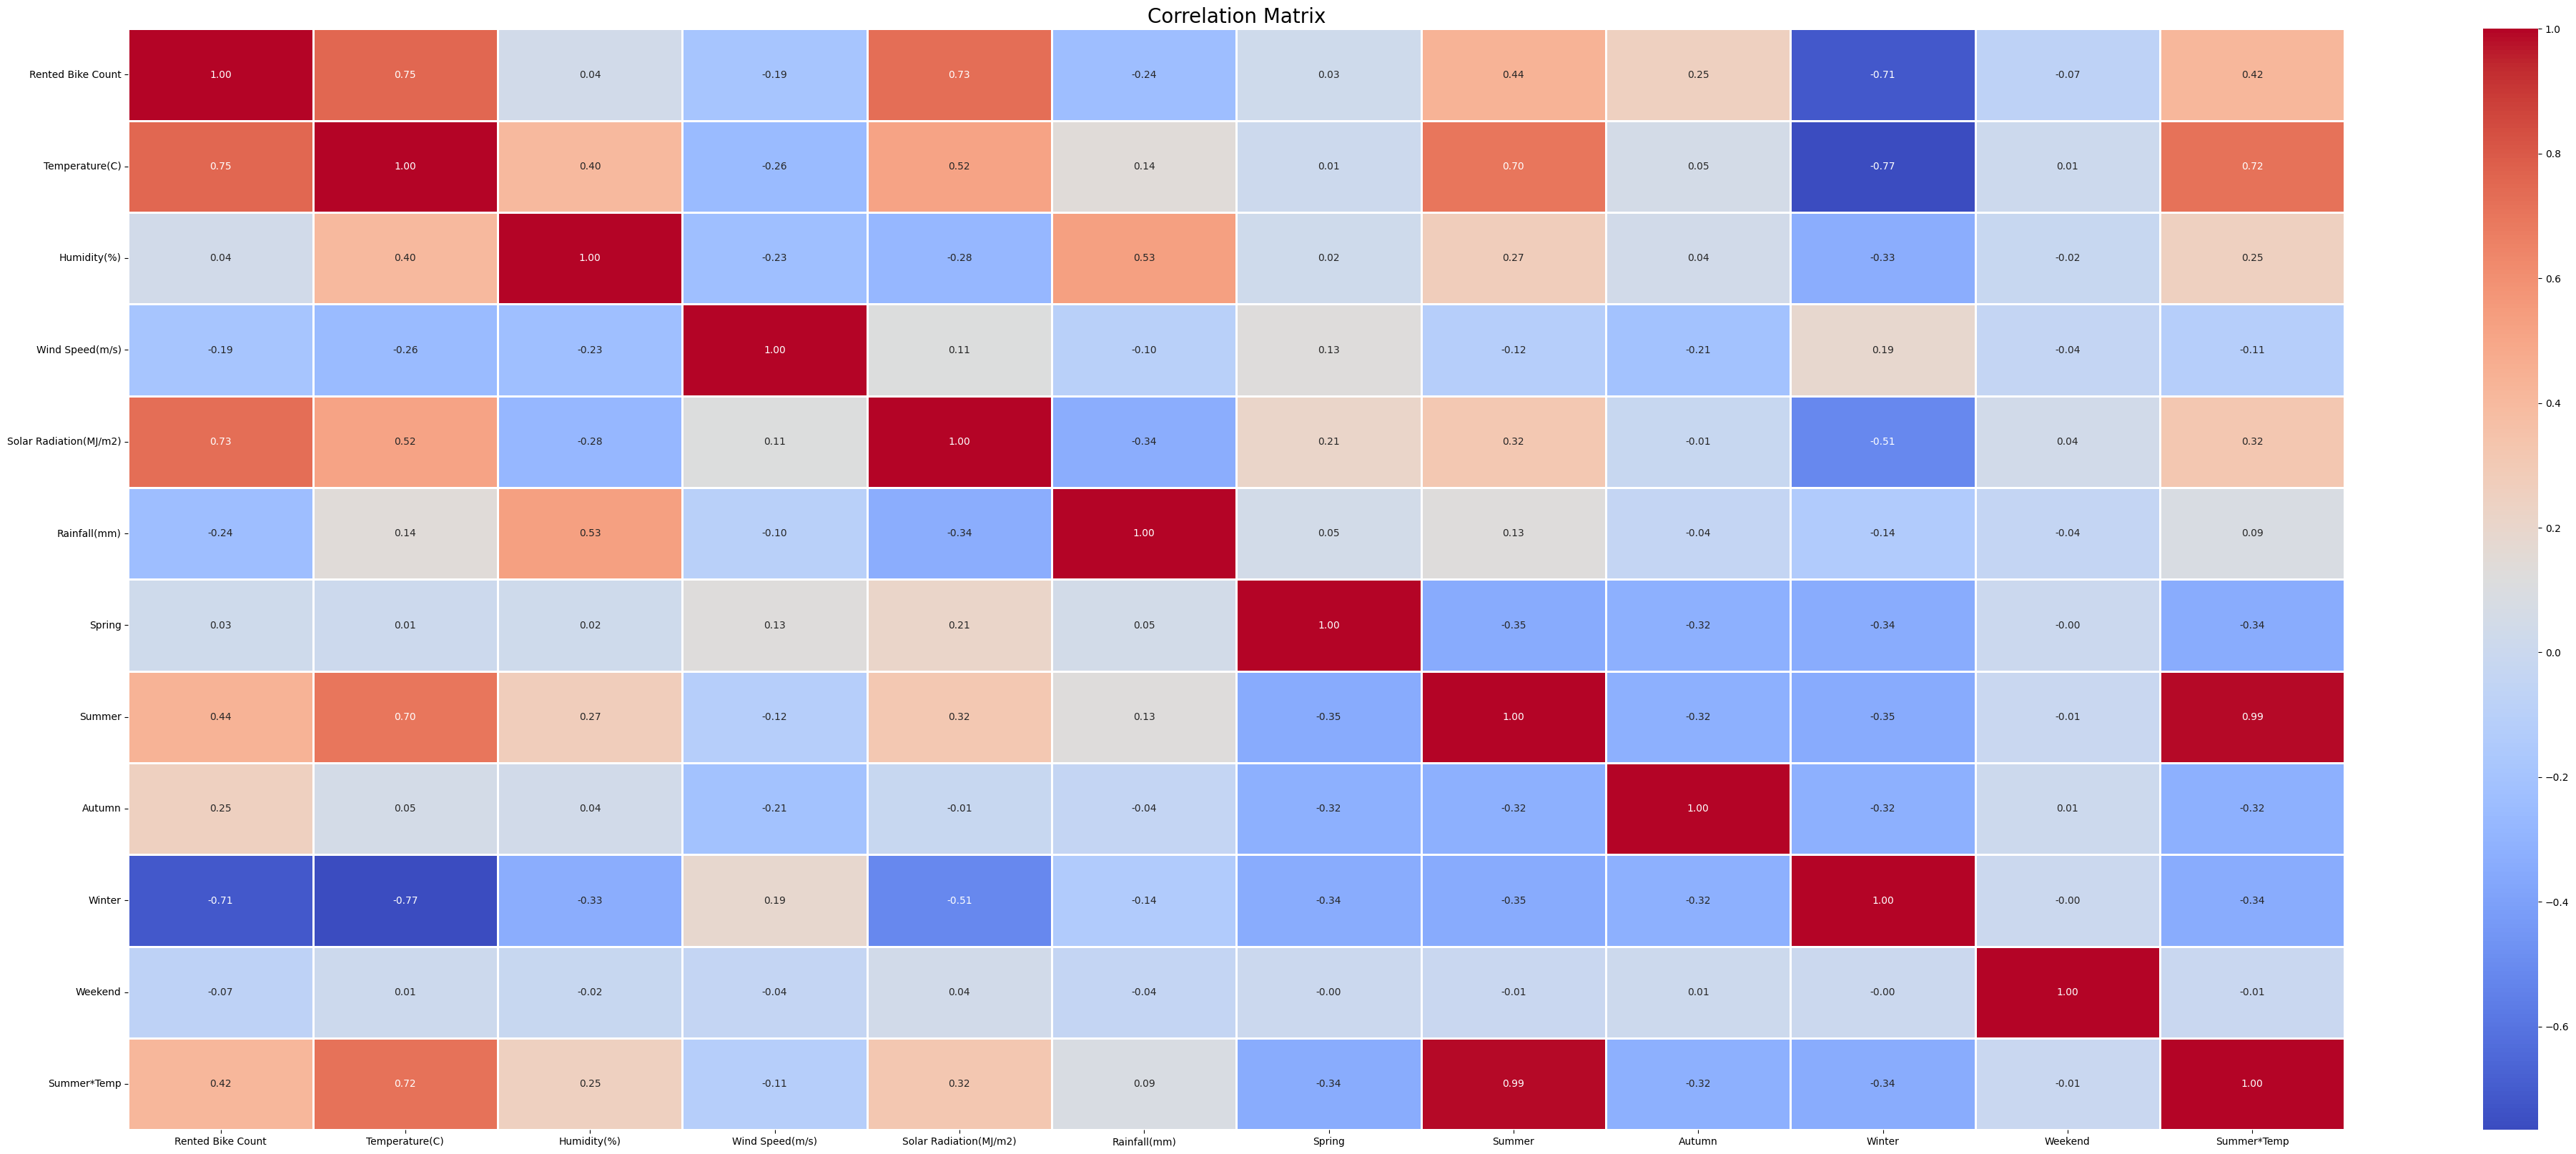

In [117]:
# doing season*temp makes it easier to explain how we captured the interaction
corr_matrix = df.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
plt.title("Correlation Matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [79]:
from sklearn.inspection import PartialDependenceDisplay

def plot_top_pdp_2d(model, X_train):
    """
    Plots 2D PDPs for the top n feature interaction pairs.
    
    Parameters:
        model: fitted scikit-learn model
        X_train: training feature DataFrame
        top_pairs: list of tuples, each with two feature names
        n: number of top interactions to plot
    """
    model.fit(X_train, y_train)  # Fit if not already
    features = list(X_train.columns)
    # Generate all unique pairs
    feature_pairs = list(itertools.combinations(features, 2))
    for i, (f1, f2) in enumerate(feature_pairs):
        print(f"\nPlotting {f1} × {f2}...")
        try:
            fig = plt.figure(figsize=(6, 5))
            display = PartialDependenceDisplay.from_estimator(
                model, X_train, [(f1, f2)], kind='average', ax=plt.gca()
            )
            plt.title(f'PDP: {f1} × {f2}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot {f1} × {f2}: {e}")


Plotting Temperature(C) × Humidity(%)...


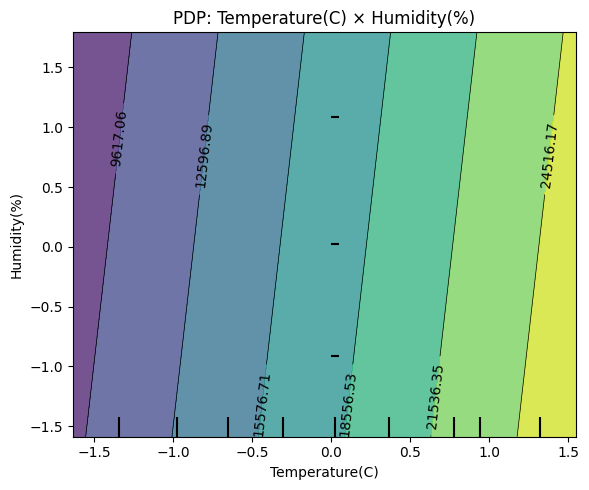


Plotting Temperature(C) × Wind Speed(m/s)...


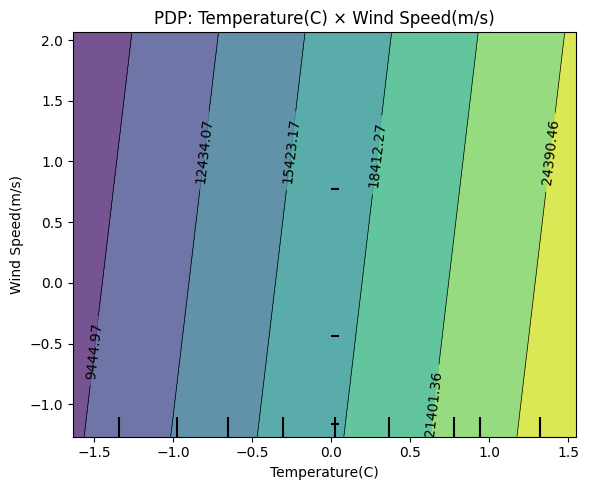


Plotting Temperature(C) × Solar Radiation(MJ/m2)...


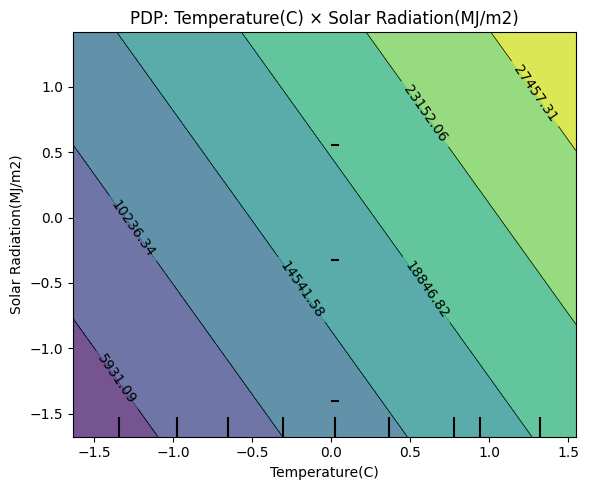


Plotting Temperature(C) × Rainfall(mm)...


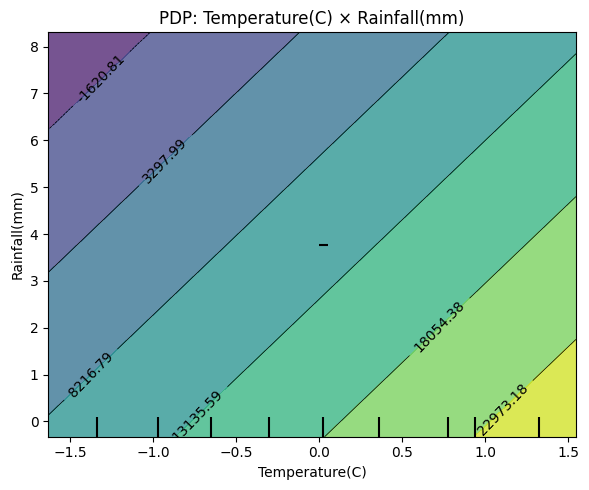


Plotting Temperature(C) × Summer*Temp...


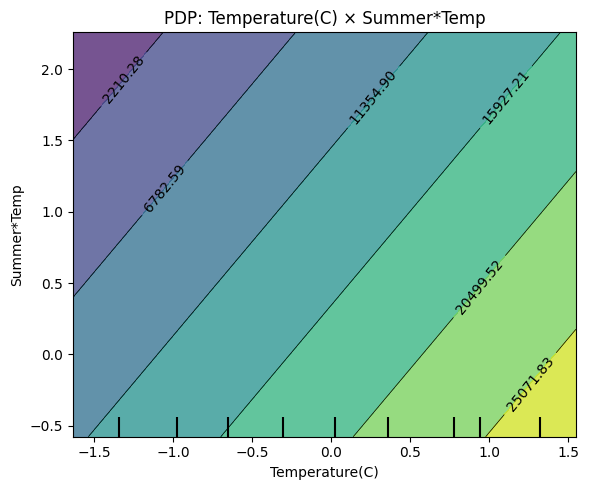


Plotting Temperature(C) × Spring...


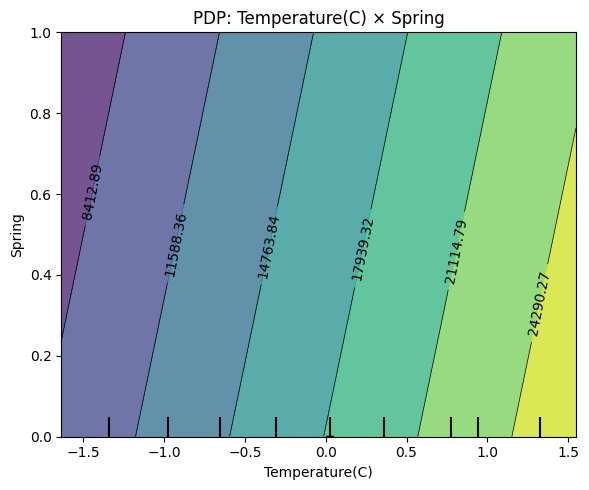


Plotting Temperature(C) × Summer...


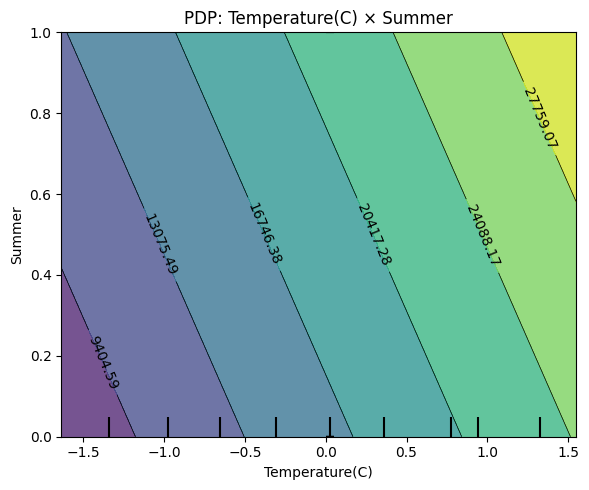


Plotting Temperature(C) × Autumn...


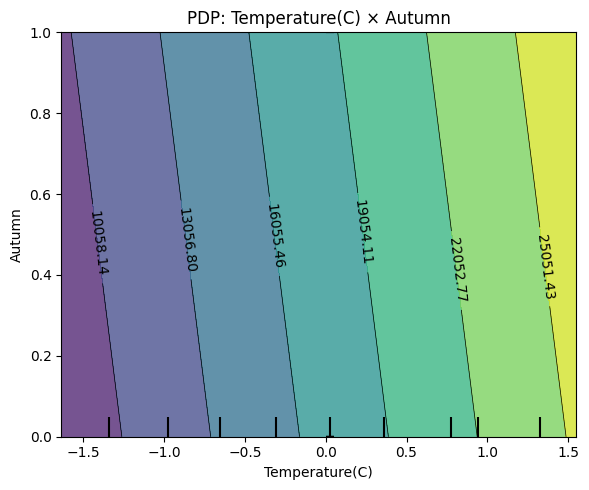


Plotting Temperature(C) × Winter...


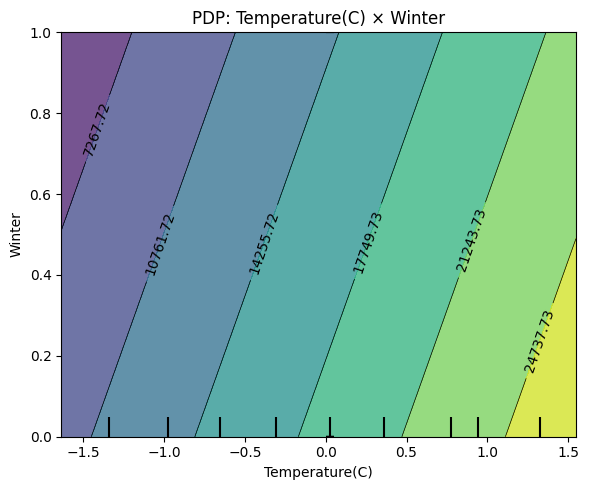


Plotting Temperature(C) × Weekend...


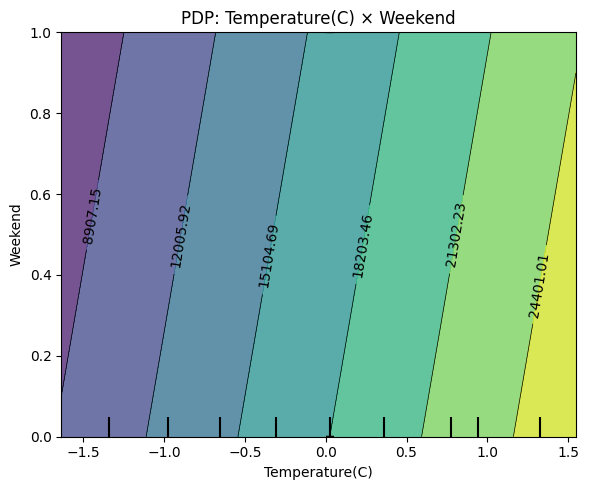


Plotting Humidity(%) × Wind Speed(m/s)...


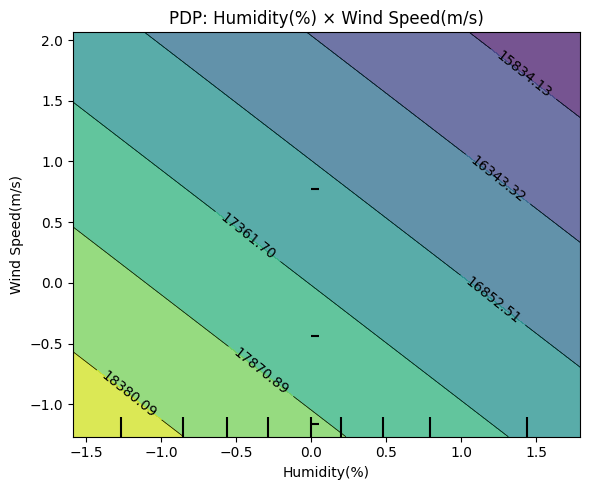


Plotting Humidity(%) × Solar Radiation(MJ/m2)...


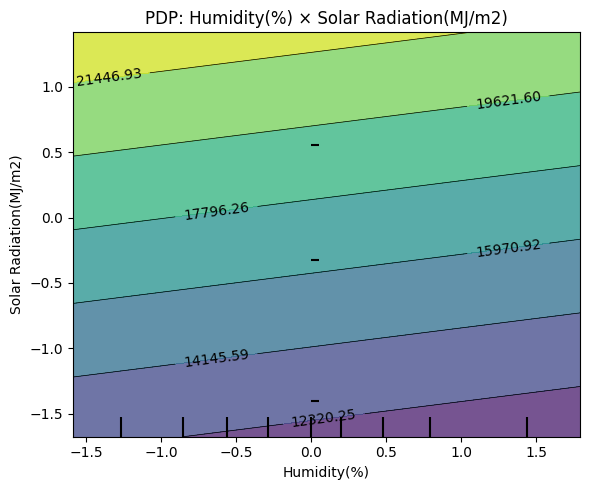


Plotting Humidity(%) × Rainfall(mm)...


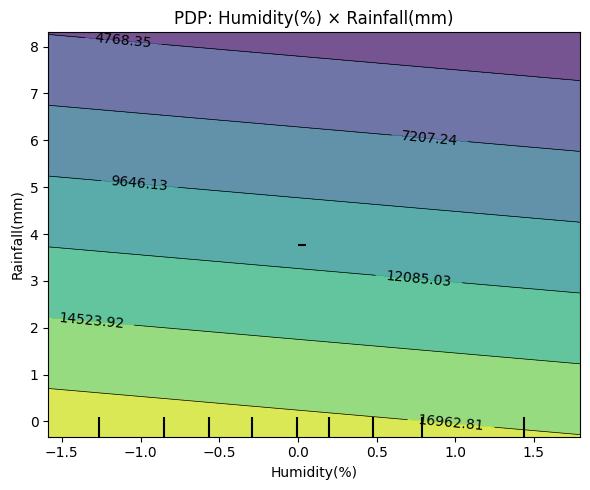


Plotting Humidity(%) × Summer*Temp...


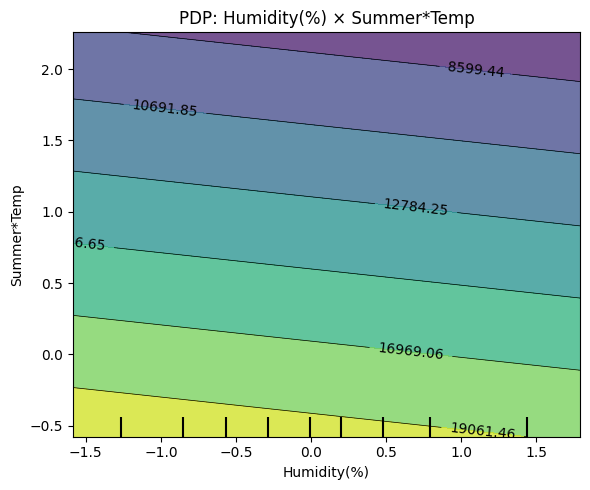


Plotting Humidity(%) × Spring...


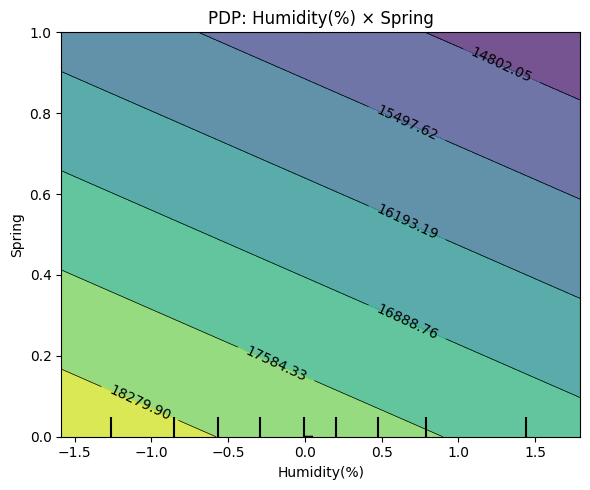


Plotting Humidity(%) × Summer...


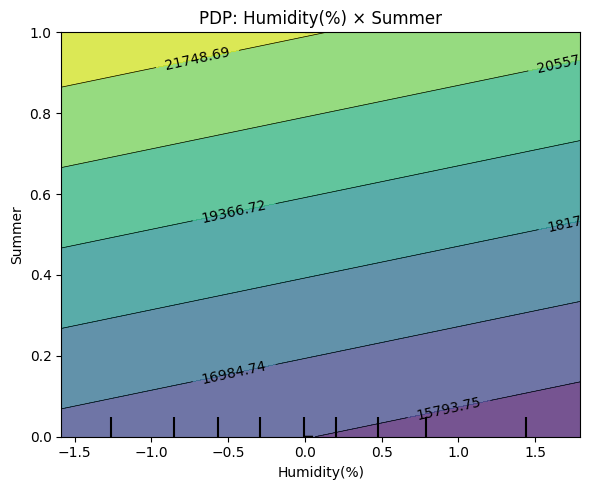


Plotting Humidity(%) × Autumn...


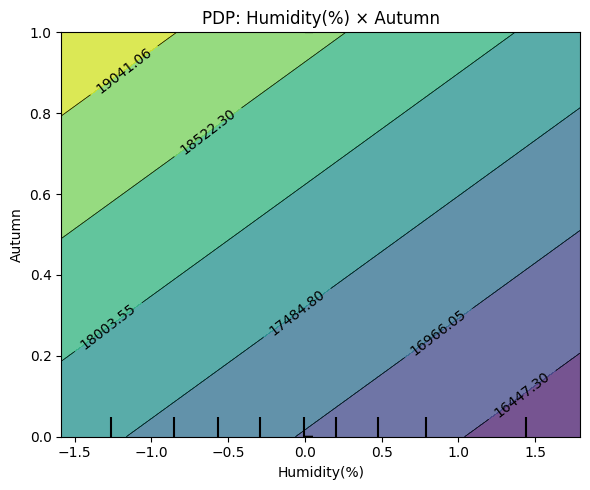


Plotting Humidity(%) × Winter...


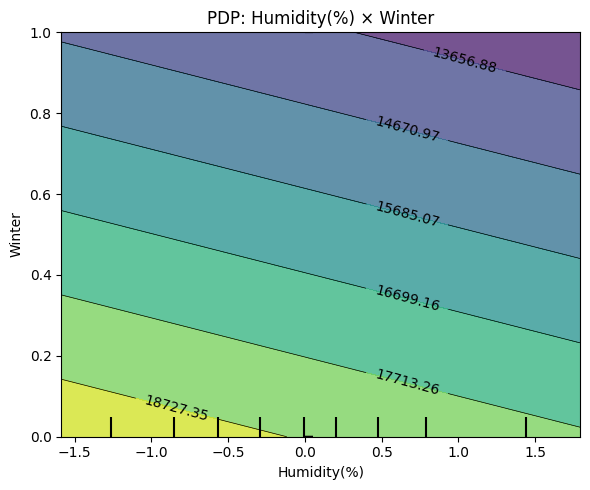


Plotting Humidity(%) × Weekend...


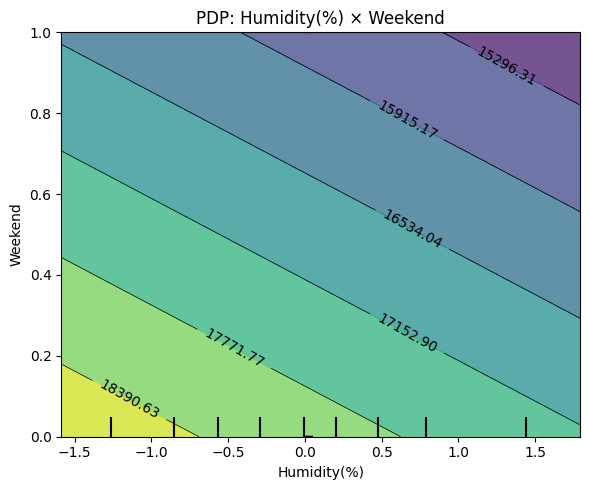


Plotting Wind Speed(m/s) × Solar Radiation(MJ/m2)...


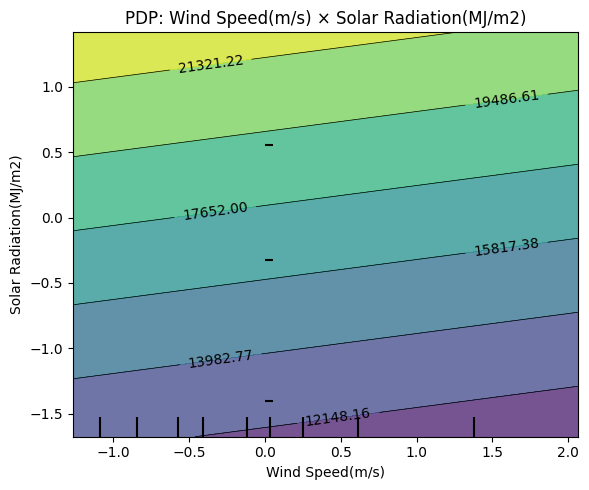


Plotting Wind Speed(m/s) × Rainfall(mm)...


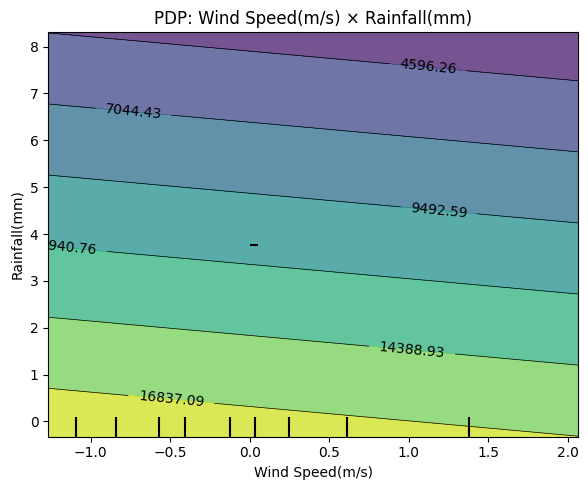


Plotting Wind Speed(m/s) × Summer*Temp...


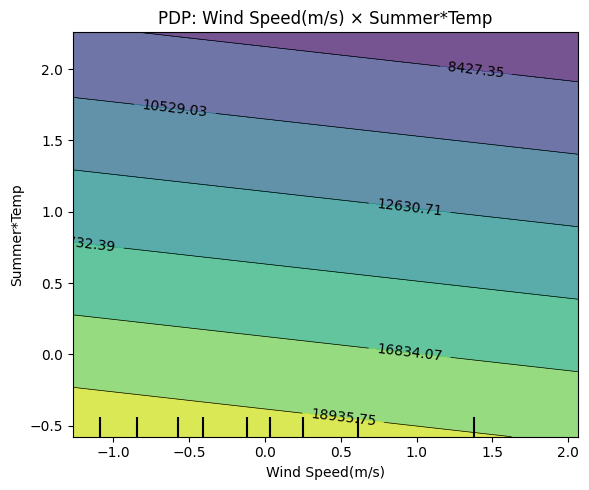


Plotting Wind Speed(m/s) × Spring...


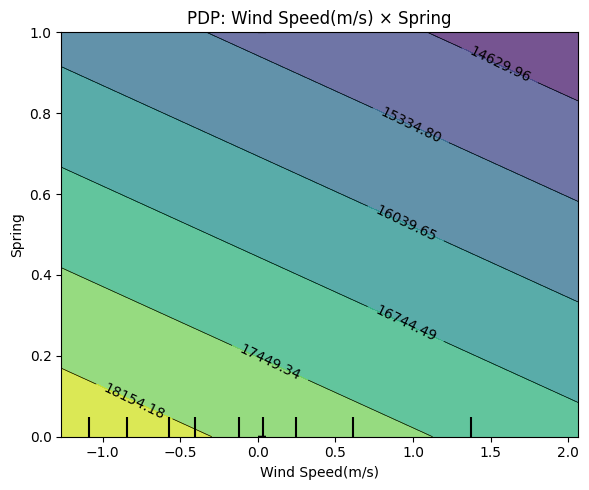


Plotting Wind Speed(m/s) × Summer...


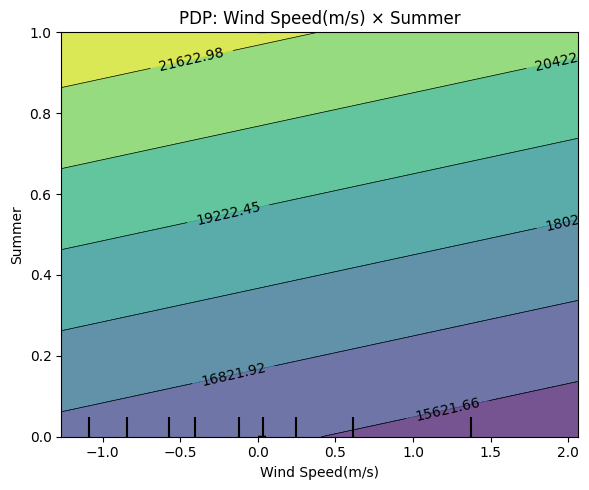


Plotting Wind Speed(m/s) × Autumn...


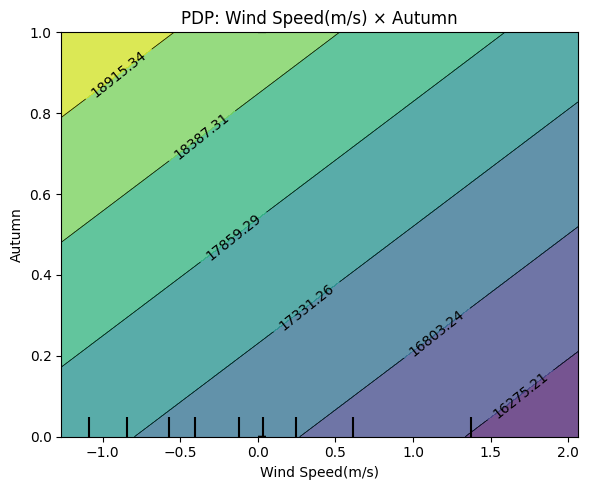


Plotting Wind Speed(m/s) × Winter...


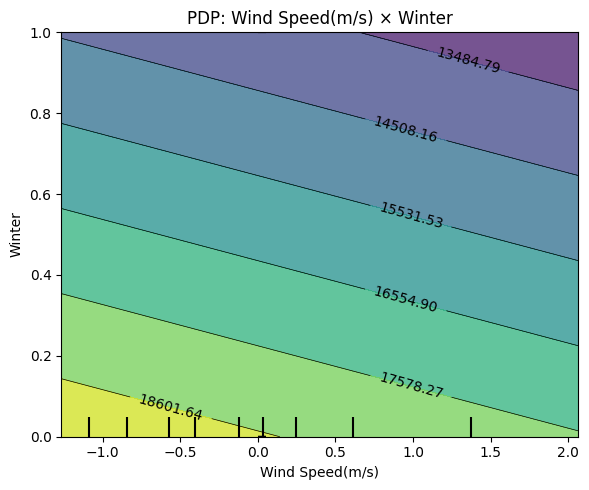


Plotting Wind Speed(m/s) × Weekend...


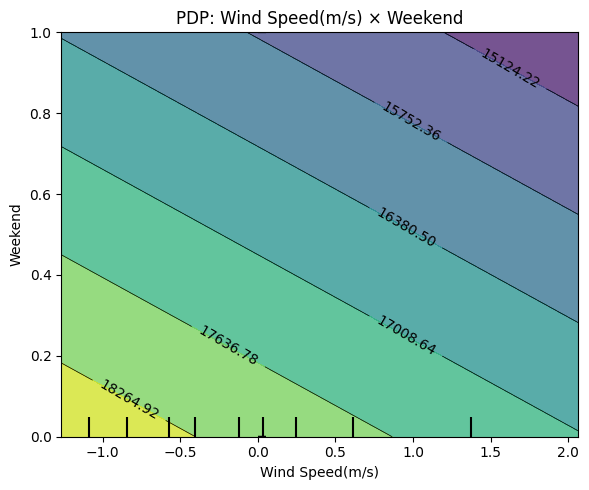


Plotting Solar Radiation(MJ/m2) × Rainfall(mm)...


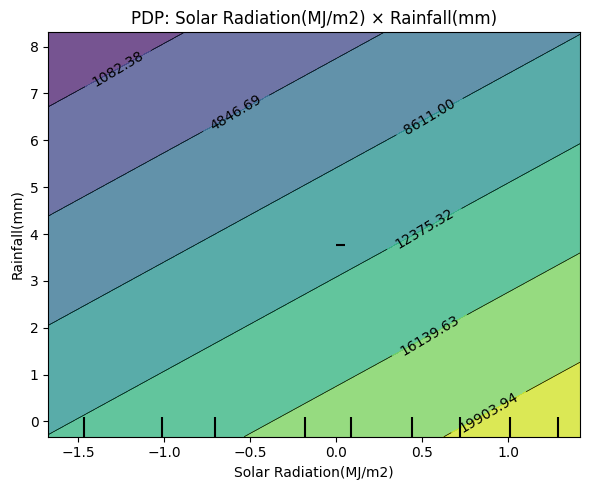


Plotting Solar Radiation(MJ/m2) × Summer*Temp...


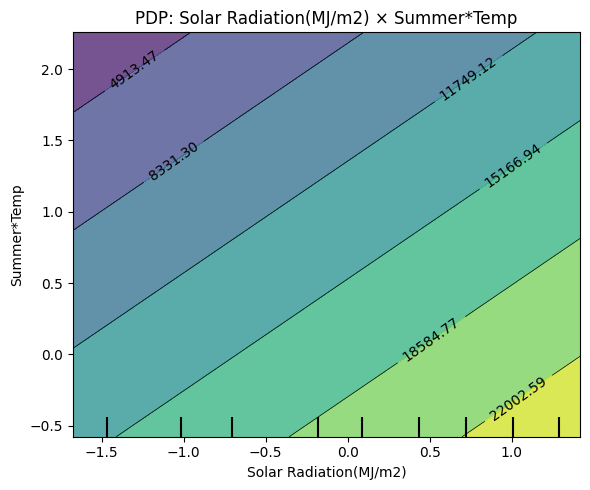


Plotting Solar Radiation(MJ/m2) × Spring...


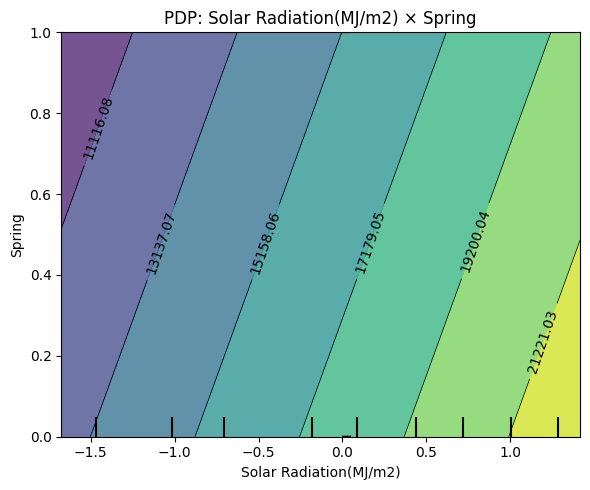


Plotting Solar Radiation(MJ/m2) × Summer...


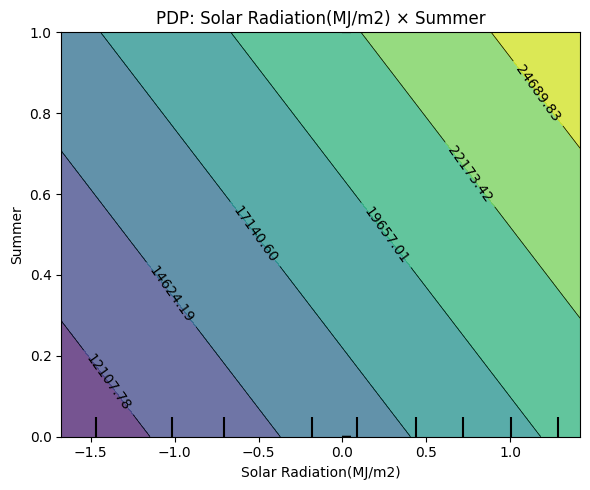


Plotting Solar Radiation(MJ/m2) × Autumn...


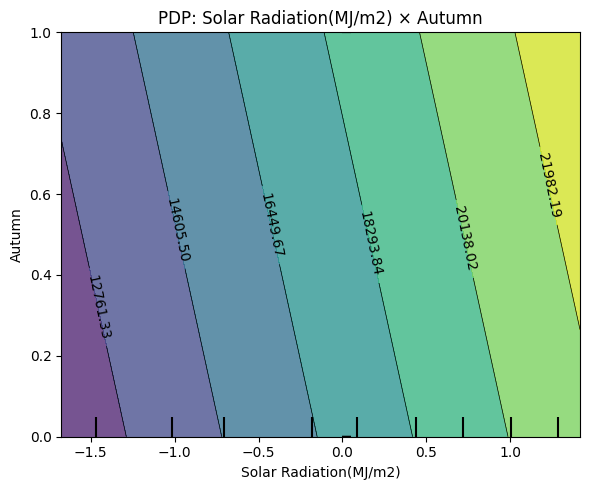


Plotting Solar Radiation(MJ/m2) × Winter...


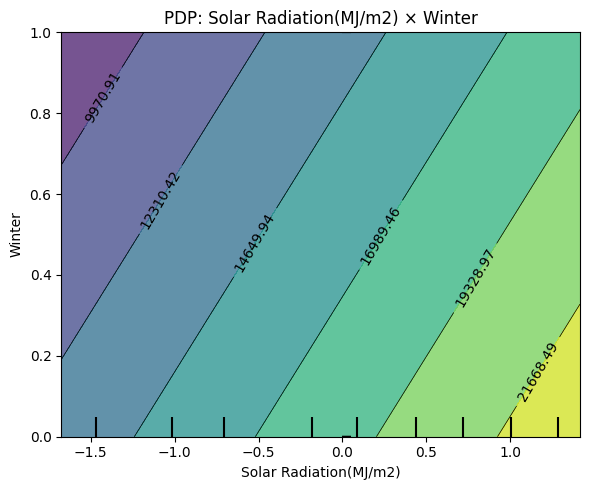


Plotting Solar Radiation(MJ/m2) × Weekend...


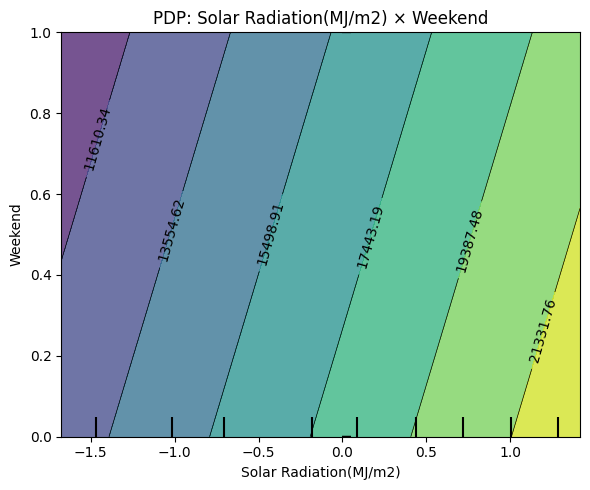


Plotting Rainfall(mm) × Summer*Temp...


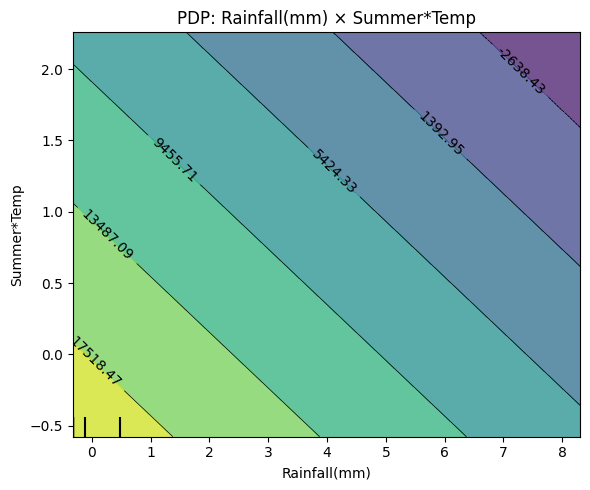


Plotting Rainfall(mm) × Spring...


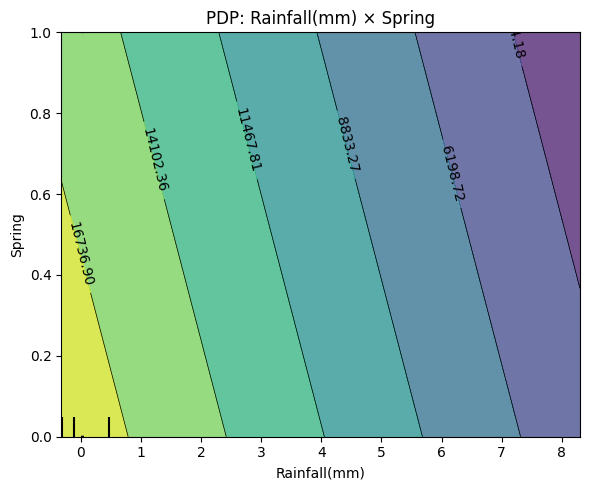


Plotting Rainfall(mm) × Summer...


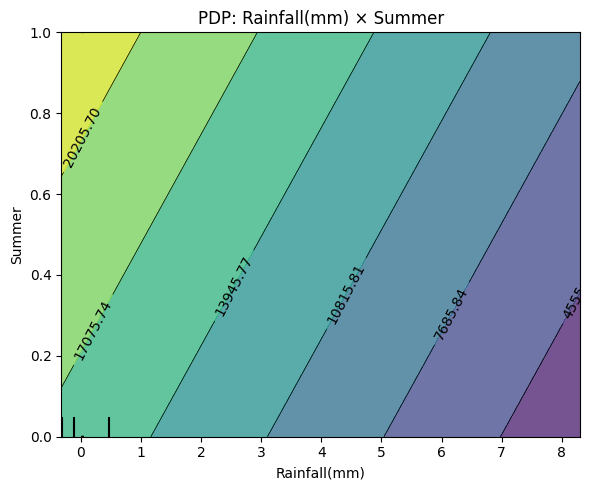


Plotting Rainfall(mm) × Autumn...


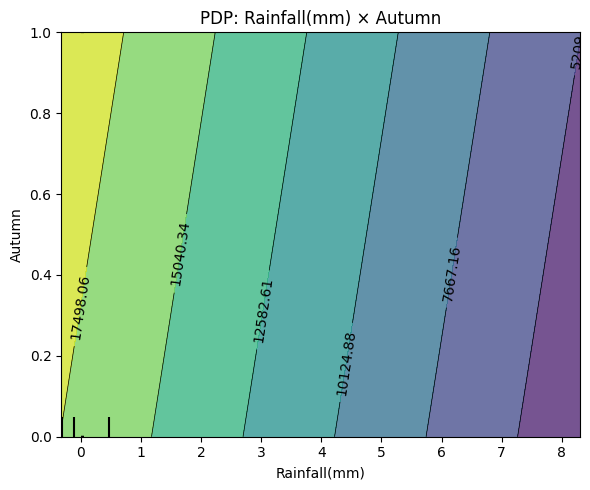


Plotting Rainfall(mm) × Winter...


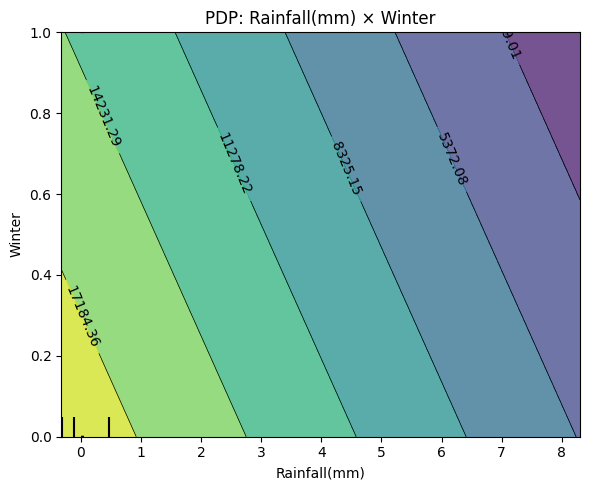


Plotting Rainfall(mm) × Weekend...


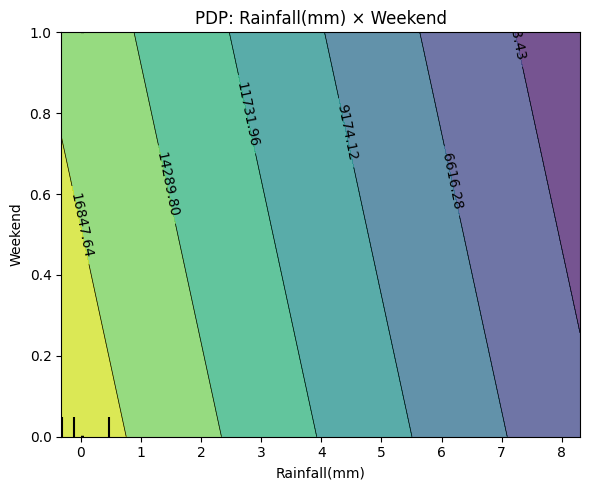


Plotting Summer*Temp × Spring...


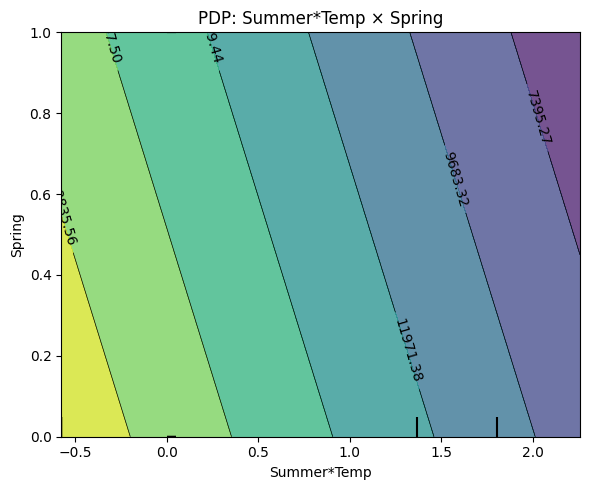


Plotting Summer*Temp × Summer...


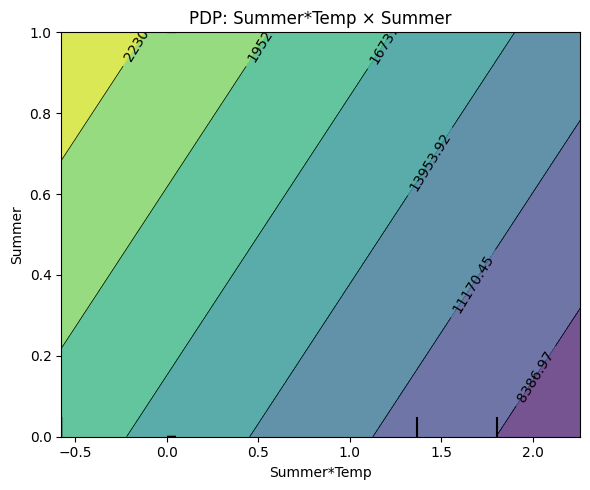


Plotting Summer*Temp × Autumn...


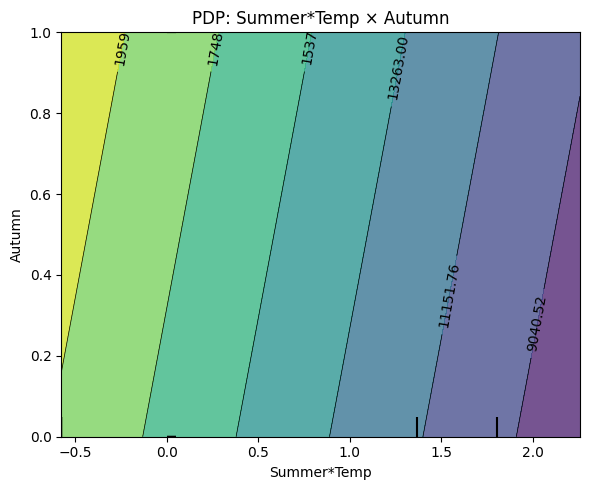


Plotting Summer*Temp × Winter...


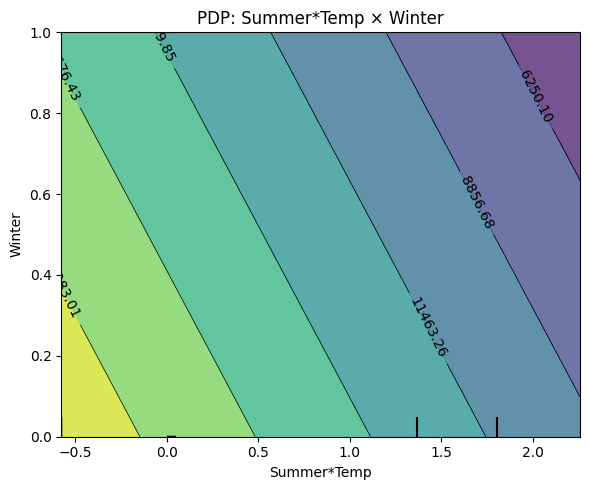


Plotting Summer*Temp × Weekend...


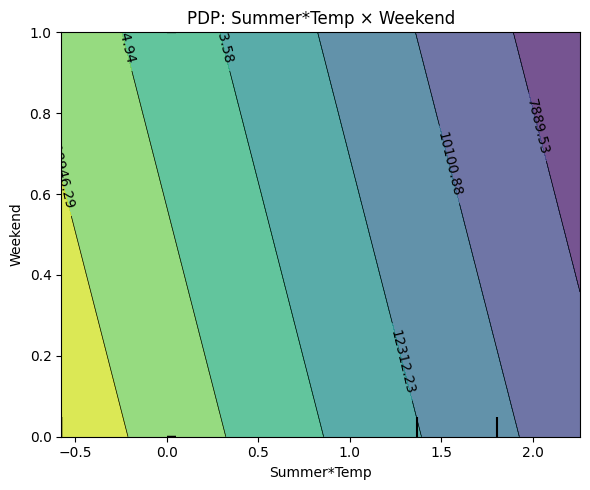


Plotting Spring × Summer...


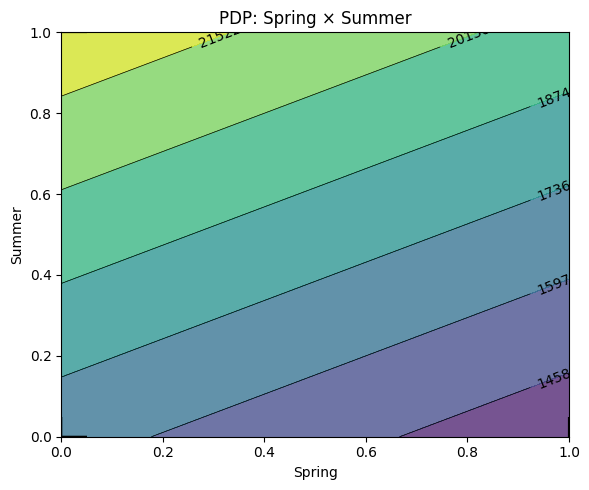


Plotting Spring × Autumn...


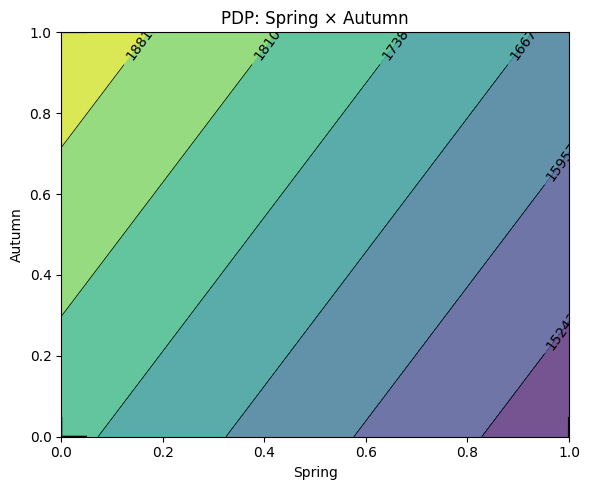


Plotting Spring × Winter...


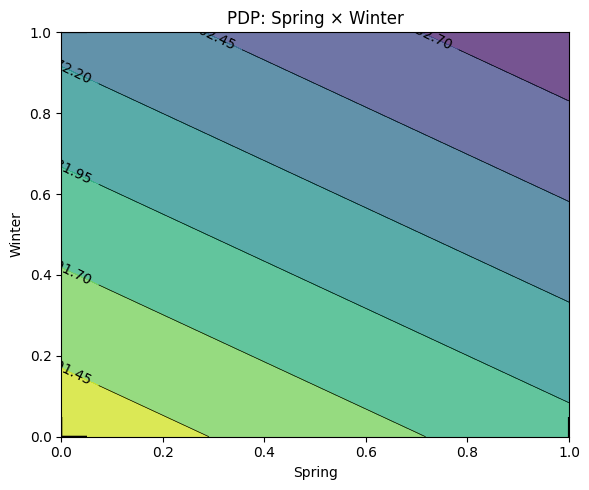


Plotting Spring × Weekend...


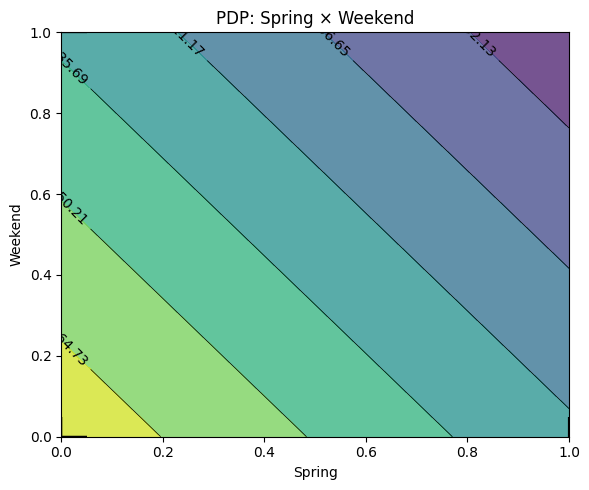


Plotting Summer × Autumn...


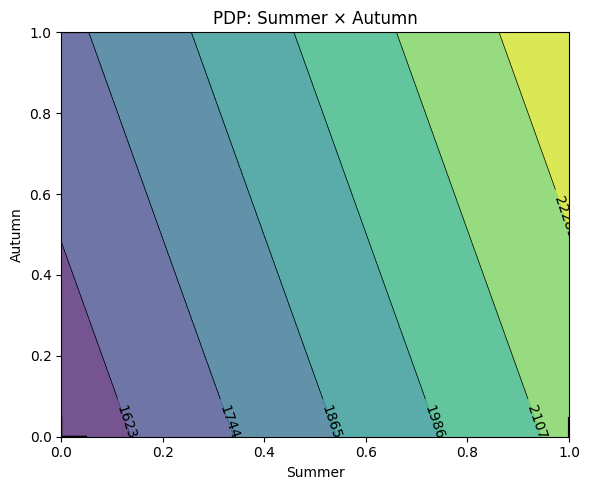


Plotting Summer × Winter...


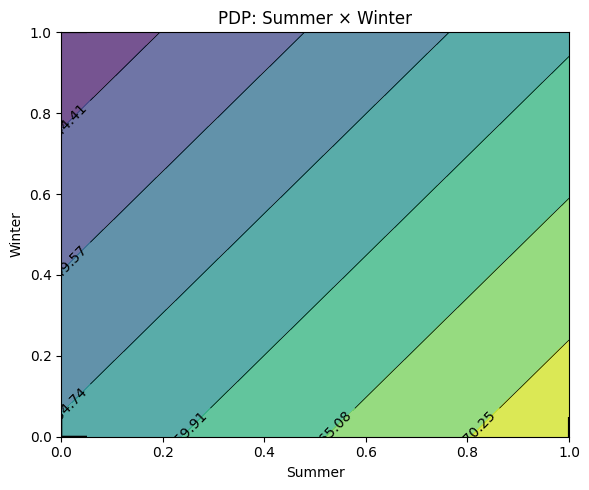


Plotting Summer × Weekend...


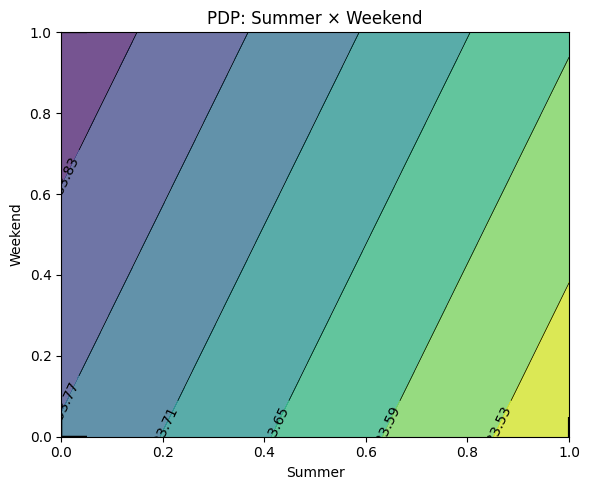


Plotting Autumn × Winter...


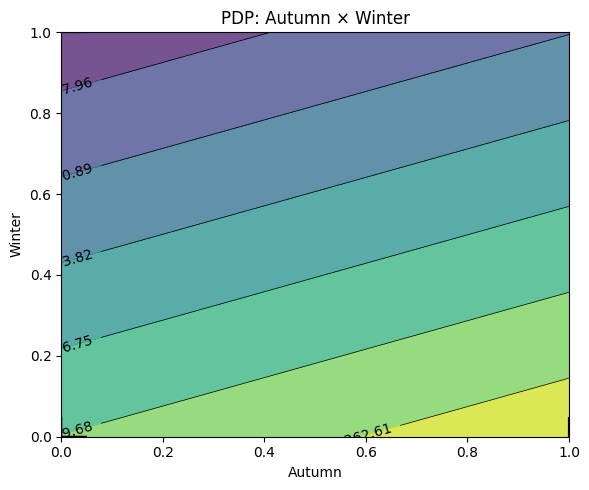


Plotting Autumn × Weekend...


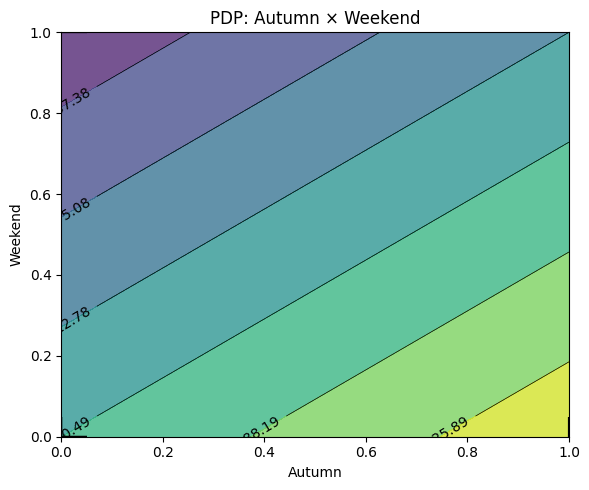


Plotting Winter × Weekend...


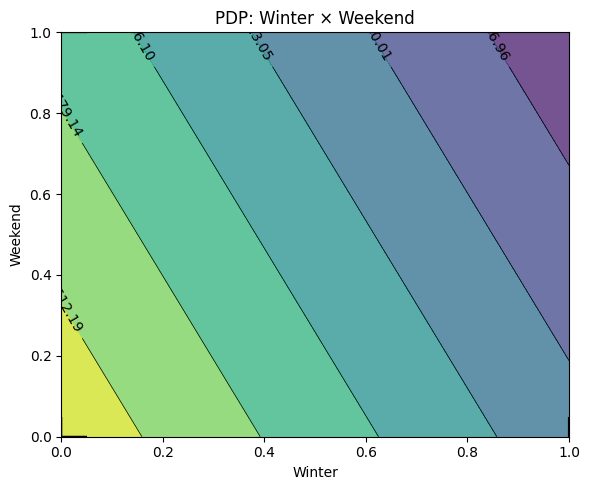

In [80]:
plot_top_pdp_2d(reg, X_train)

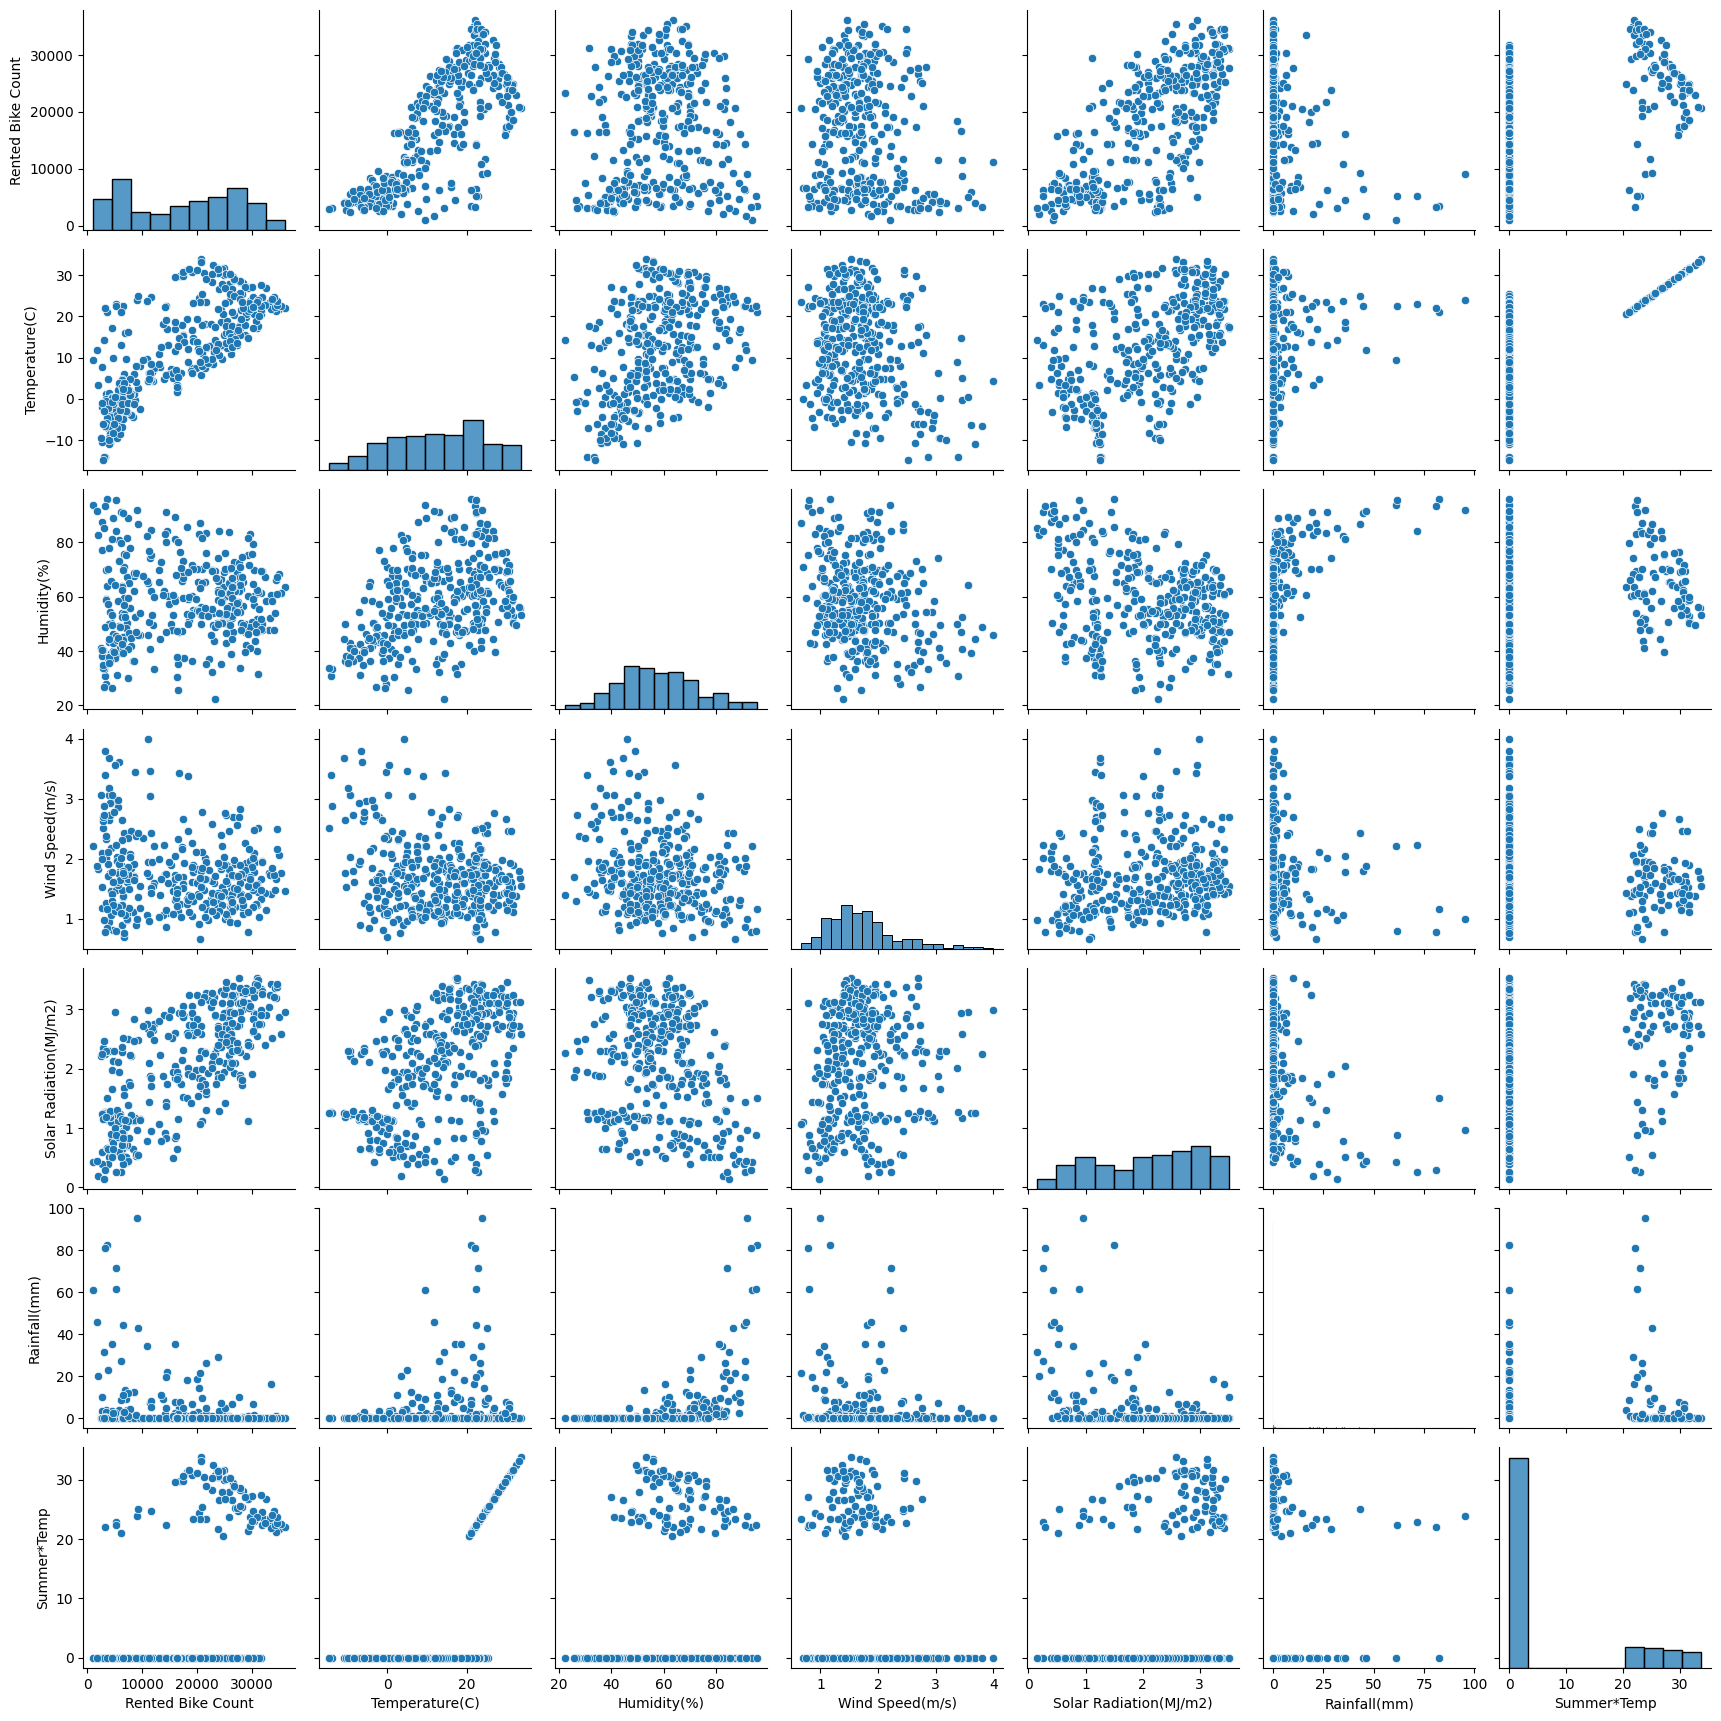

In [116]:
pair = ['Rented Bike Count', 'Temperature(C)', 'Humidity(%)', 'Wind Speed(m/s)', 'Solar Radiation(MJ/m2)', 'Rainfall(mm)', 'Summer*Temp']
sns.pairplot(df[pair])
plt.show()